#### STEP 1 : 시계열 데이터 준비

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/daily-min-temperatures.csv' 
from pathlib import Path
directory = Path.joinpath(Path.cwd(),'data')


# Nvidia 주가예측

In [193]:
dataset_filepath = Path.joinpath(directory, 'NVDA.csv')
dataset_filepath = str(dataset_filepath)
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2017-02-17    26.807501
2017-02-21    27.767500
2017-02-22    27.690001
2017-02-23    25.122499
2017-02-24    25.365000
Name: Close, dtype: float64

#### STEP 2 : 각종 전처리 수행  
결측치 처리  
로그 변환

In [194]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [195]:
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [196]:
# 로그 변환
ts_log = np.log(ts)
# ts_log = ts

#### STEP 3 : 시계열 안정성 분석  
정성적 그래프 분석  
정량적 Augmented Dicky-Fuller Test  
시계열 분해(Time Series Decomposition)  
Residual 안정성 확인

In [197]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [198]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd  = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',  label='Original')    
    mean = plt.plot(rolmean,    color='red',   label='Rolling Mean')
    std  = plt.plot(rolstd,     color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

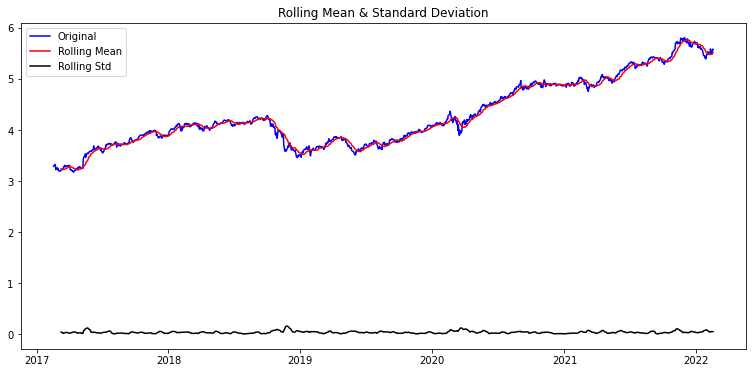

Results of Dickey-Fuller Test:
Test Statistic                   -0.352307
p-value                           0.917763
#Lags Used                        8.000000
Number of Observations Used    1250.000000
Critical Value (1%)              -3.435592
Critical Value (5%)              -2.863855
Critical Value (10%)             -2.568003
dtype: float64


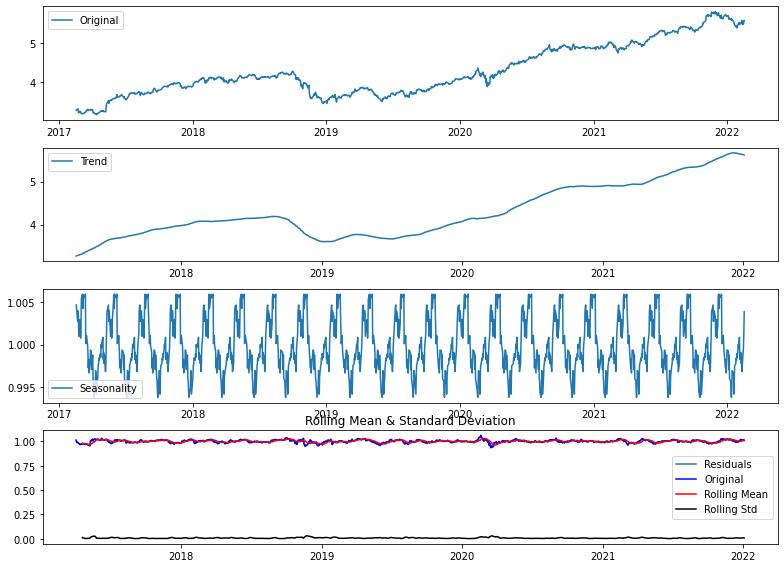

In [199]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=15)
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 60) 
trend         = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal      = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual      = decomposition.resid # 원본(로그변환한) - 추세 - 계절성
plt.rcParams["figure.figsize"] = (11,8)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

### 주식차트에서 흔히 사용되는 15일 평균선을 사용해서 나타내 보았지만 별다른 규칙성이라곤 찾아볼 수가 없다. p-value 또한 0.917763로 주기성이나 방향성이 가지고 있다고 보기는 어렵다.

#### STEP 4 : 학습, 테스트 데이터셋 생성

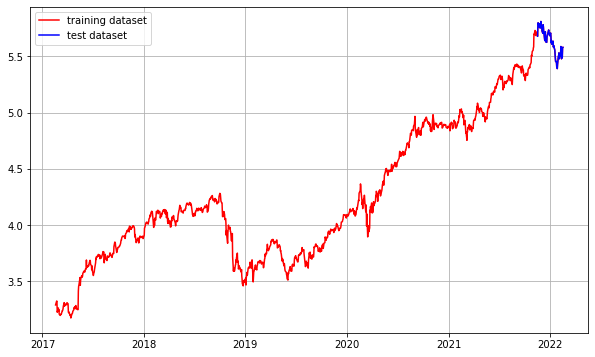

In [200]:
train_data, test_data = ts_log[:int(len(ts_log)*0.95)], ts_log[int(len(ts_log)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### STEP 5 : 적정 ARIMA 모수 찾기

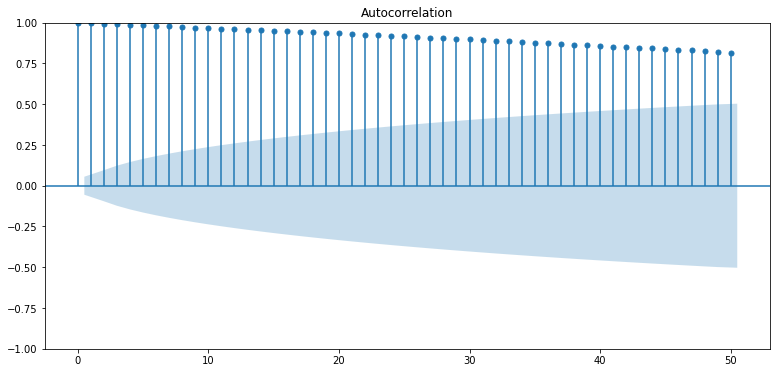

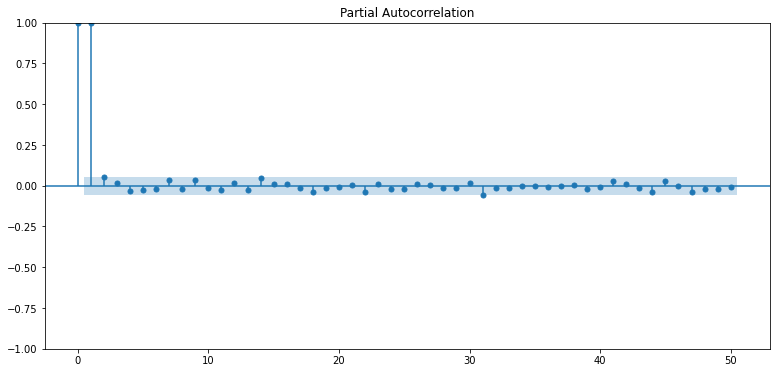

In [201]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log, lags=50)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log, lags=50)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### pacf그래프로 p값을 찾아보면 32 정도로 보인다. acf 그래프로 q값을 찾아보면 0정도로 보인다.

Results of Dickey-Fuller Test:
Test Statistic                -1.317908e+01
p-value                        1.206394e-24
#Lags Used                     7.000000e+00
Number of Observations Used    1.250000e+03
Critical Value (1%)           -3.435592e+00
Critical Value (5%)           -2.863855e+00
Critical Value (10%)          -2.568003e+00
dtype: float64


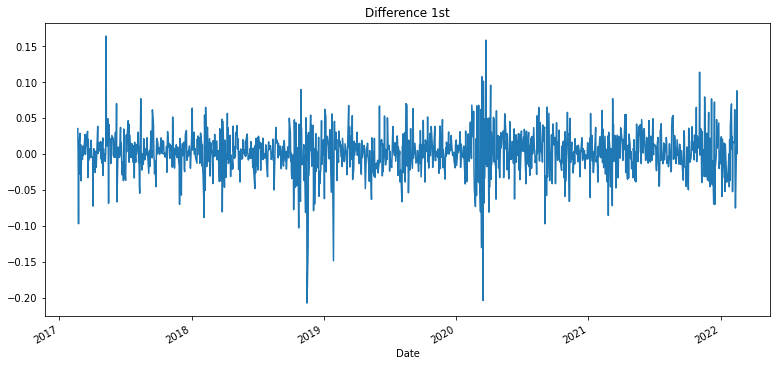

In [202]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### 1차미분에 대한 p-value 1.206394e-24로 작은 값이며 d = 1값을 사용하였다.

#### STEP 6 : ARIMA 모델 훈련과 테스트  
ARIMA 모델 빌드와 훈련  
모델 테스트 및 플로팅  
최종 예측 모델 정확도 측정(MAPE)

In [203]:
from statsmodels.tsa.arima.model import ARIMA
# Build and Train  Model
model = ARIMA(train_data, order=(32, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1196
Model:                ARIMA(32, 1, 0)   Log Likelihood                2543.281
Date:                Thu, 17 Feb 2022   AIC                          -5020.562
Time:                        21:45:03   BIC                          -4852.727
Sample:                             0   HQIC                         -4957.327
                               - 1196                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0780      0.020     -3.919      0.000      -0.117      -0.039
ar.L2          0.0565      0.026      2.187      0.029       0.006       0.107
ar.L3          0.0206      0.026      0.794      0.4

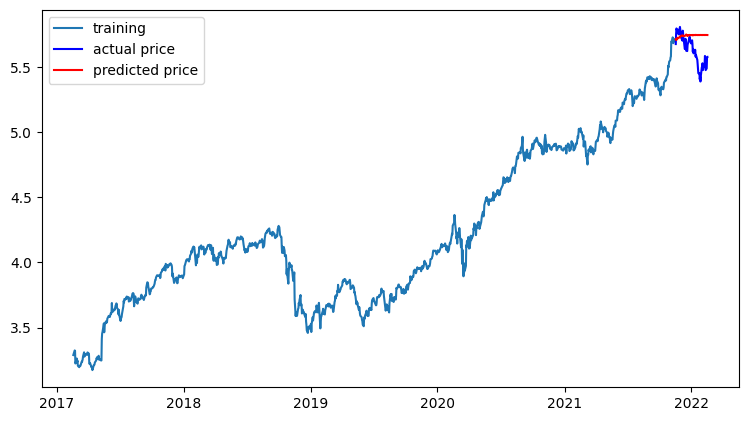

In [204]:

fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [205]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2104.7812361282877
MAE:  37.53483502006418
RMSE:  45.877894852840484
MAPE: 14.63%


# Apple 주가 예측

In [206]:
dataset_filepath = Path.joinpath(directory, 'AAPL.csv')
df = pd.read_csv(dataset_filepath) 
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-02-17,33.775002,33.957500,33.775002,33.930000,32.035347,88792800
1,2017-02-21,34.057499,34.187500,33.994999,34.174999,32.266659,98028800
2,2017-02-22,34.107498,34.279999,34.027500,34.277500,32.363445,83347600
3,2017-02-23,34.345001,34.369999,34.075001,34.132500,32.226532,83152800
4,2017-02-24,33.977501,34.165001,33.820000,34.165001,32.257221,87106400


#### STEP 2 : 각종 전처리 수행  
결측치 처리  
로그 변환

In [207]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [208]:
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [209]:
# 로그 변환
ts_log = np.log(ts)
# ts_log = ts

#### STEP 3 : 시계열 안정성 분석  
정성적 그래프 분석  
정량적 Augmented Dicky-Fuller Test  
시계열 분해(Time Series Decomposition)  
Residual 안정성 확인

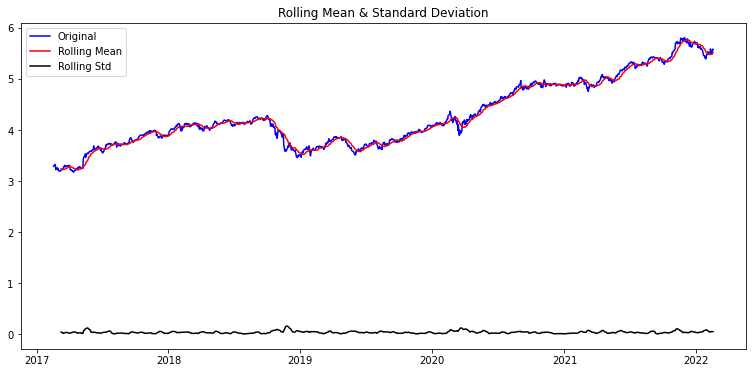

Results of Dickey-Fuller Test:
Test Statistic                   -0.352307
p-value                           0.917763
#Lags Used                        8.000000
Number of Observations Used    1250.000000
Critical Value (1%)              -3.435592
Critical Value (5%)              -2.863855
Critical Value (10%)             -2.568003
dtype: float64


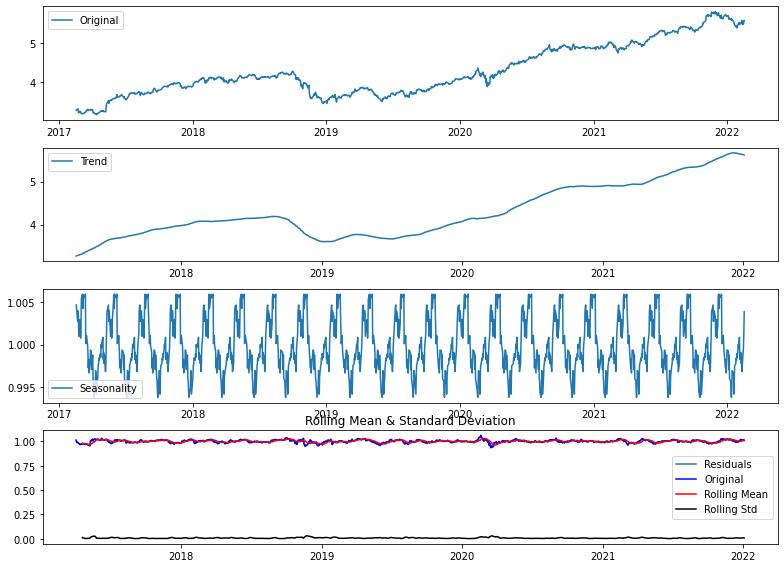

In [210]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=15)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 60) 
trend         = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal      = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual      = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,8)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

### 주식차트에서 흔히 사용되는 15일 평균선을 사용해서 나타내 보았지만 별다른 규칙성이라곤 찾아볼 수가 없다. p-value 또한 0.917763 으로 주기성이나 방향성이 가지고 있다고 보기는 어렵다.

#### STEP 4 : 학습, 테스트 데이터셋 생성

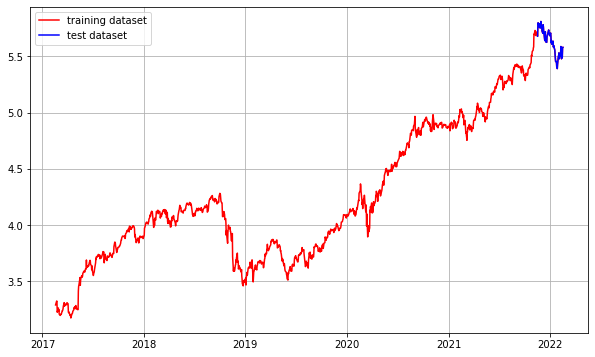

In [211]:
train_data, test_data = ts_log[:int(len(ts_log)*0.95)], ts_log[int(len(ts_log)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### STEP 5 : 적정 ARIMA 모수 찾기

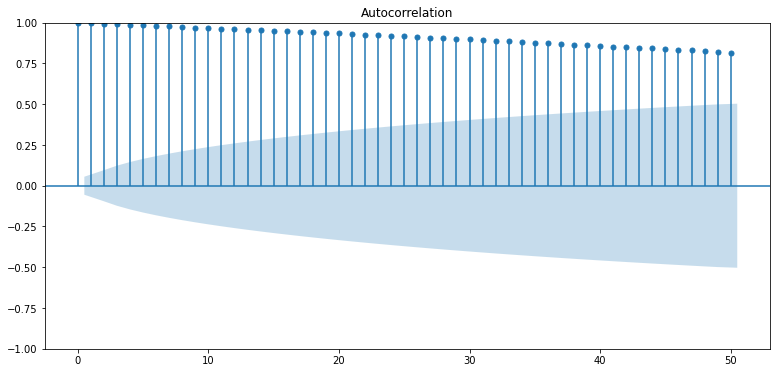

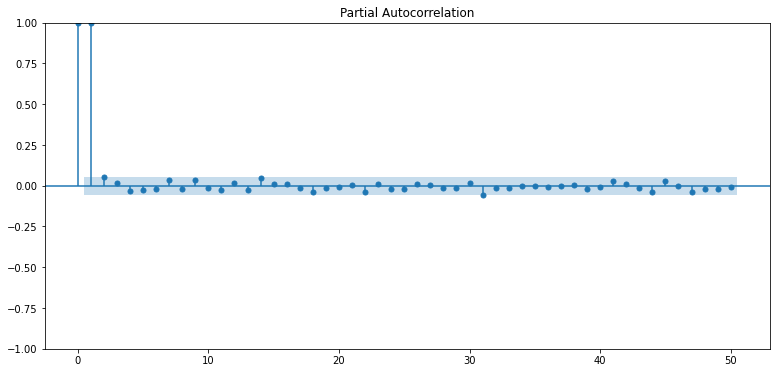

In [212]:
plot_acf(ts_log, lags=50)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log, lags=50)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### pacf그래프로 p값을 찾아보면 32 정도로 보인다. acf 그래프로 q값을 찾아보면 0정도로 보인다.

Results of Dickey-Fuller Test:
Test Statistic                -1.317908e+01
p-value                        1.206394e-24
#Lags Used                     7.000000e+00
Number of Observations Used    1.250000e+03
Critical Value (1%)           -3.435592e+00
Critical Value (5%)           -2.863855e+00
Critical Value (10%)          -2.568003e+00
dtype: float64


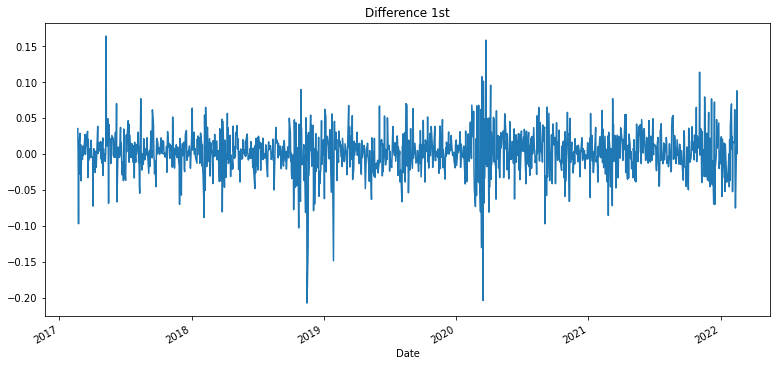

In [213]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### 1차미분에 대한 p-value 1.206394e-24로 작은 값이며 d = 1값을 사용하였다.

#### STEP 6 : ARIMA 모델 훈련과 테스트  
ARIMA 모델 빌드와 훈련  
모델 테스트 및 플로팅  
최종 예측 모델 정확도 측정(MAPE)

In [214]:
from statsmodels.tsa.arima.model import ARIMA
# Build and Train  Model
model = ARIMA(train_data, order=(32, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1196
Model:                ARIMA(32, 1, 0)   Log Likelihood                2543.281
Date:                Thu, 17 Feb 2022   AIC                          -5020.562
Time:                        21:45:15   BIC                          -4852.727
Sample:                             0   HQIC                         -4957.327
                               - 1196                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0780      0.020     -3.919      0.000      -0.117      -0.039
ar.L2          0.0565      0.026      2.187      0.029       0.006       0.107
ar.L3          0.0206      0.026      0.794      0.4

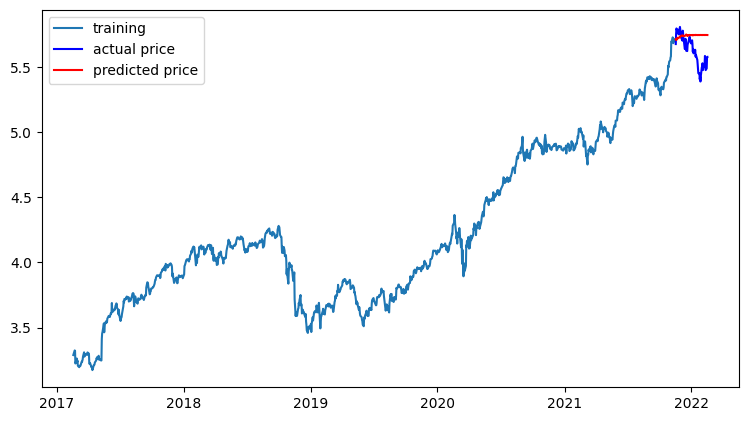

In [215]:
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [216]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2104.7812361282877
MAE:  37.53483502006418
RMSE:  45.877894852840484
MAPE: 14.63%


# 3M 주가예측

In [217]:
dataset_filepath = Path.joinpath(directory, 'MMM.csv')
dataset_filepath = str(dataset_filepath)

df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2017-02-17    182.949997
2017-02-21    183.369995
2017-02-22    186.039993
2017-02-23    187.190002
2017-02-24    187.410004
Name: Close, dtype: float64

#### STEP 2 : 각종 전처리 수행  
결측치 처리  
로그 변환

In [218]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [219]:
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [220]:
# 로그 변환
ts_log = np.log(ts)
# ts_log = ts

#### STEP 3 : 시계열 안정성 분석  
정성적 그래프 분석  
정량적 Augmented Dicky-Fuller Test  
시계열 분해(Time Series Decomposition)  
Residual 안정성 확인

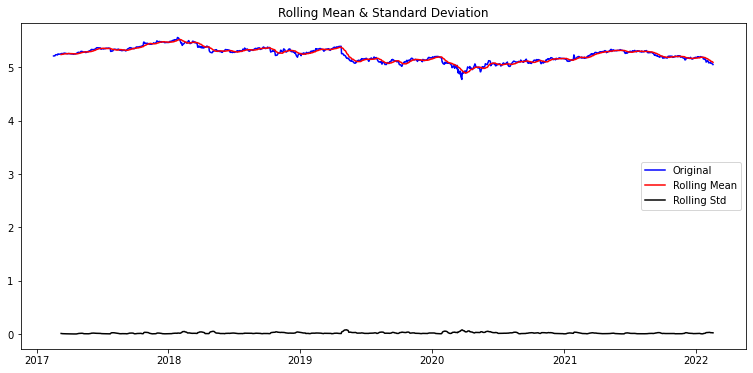

Results of Dickey-Fuller Test:
Test Statistic                   -1.552637
p-value                           0.507331
#Lags Used                       14.000000
Number of Observations Used    1244.000000
Critical Value (1%)              -3.435618
Critical Value (5%)              -2.863866
Critical Value (10%)             -2.568008
dtype: float64


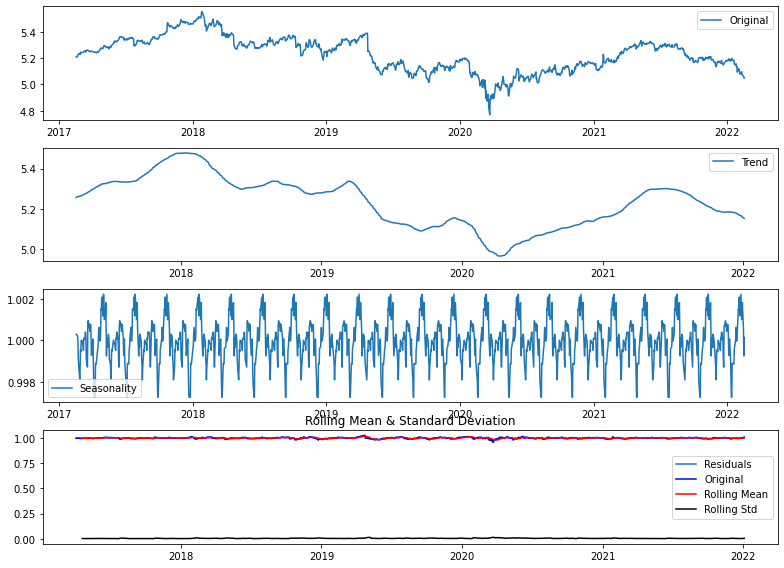

In [221]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=15)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 60) 
trend         = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal      = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual      = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,8)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

### 주식차트에서 흔히 사용되는 15일 평균선을 사용해서 나타내 보았지만 별다른 규칙성이라곤 찾아볼 수가 없다. p-value 또한 0.507331 으로 주기성이나 방향성이 가지고 있다고 보기는 어렵다.

#### STEP 4 : 학습, 테스트 데이터셋 생성

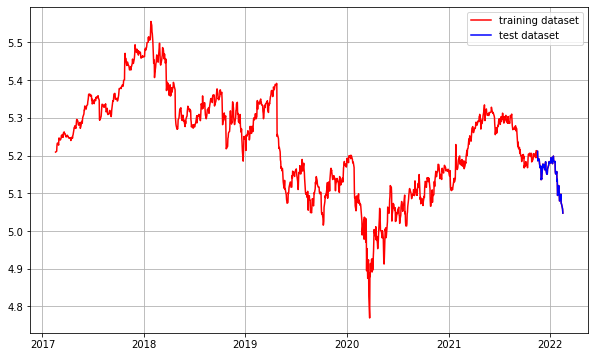

In [222]:
train_data, test_data = ts_log[:int(len(ts_log)*0.95)], ts_log[int(len(ts_log)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### STEP 5 : 적정 ARIMA 모수 찾기

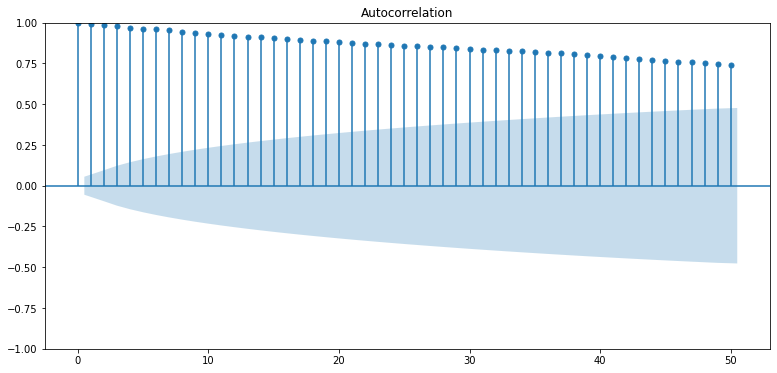

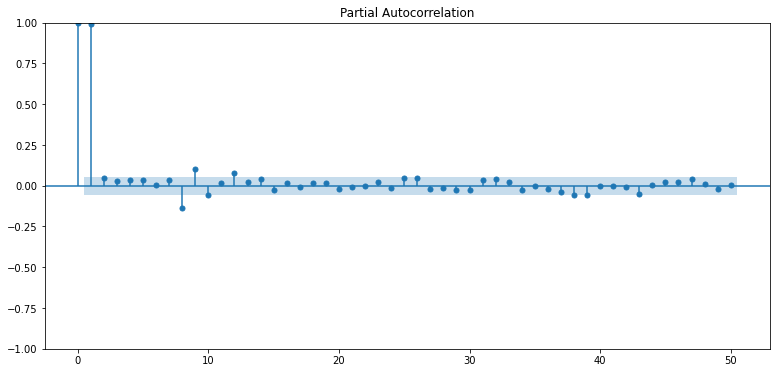

In [223]:
plot_acf(ts_log, lags=50)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log, lags=50)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### pacf그래프로 p값을 찾아보면 13 정도로 보인다. acf 그래프로 q값을 찾아보면 0정도로 보인다.

Results of Dickey-Fuller Test:
Test Statistic                -1.004344e+01
p-value                        1.475532e-17
#Lags Used                     1.300000e+01
Number of Observations Used    1.244000e+03
Critical Value (1%)           -3.435618e+00
Critical Value (5%)           -2.863866e+00
Critical Value (10%)          -2.568008e+00
dtype: float64


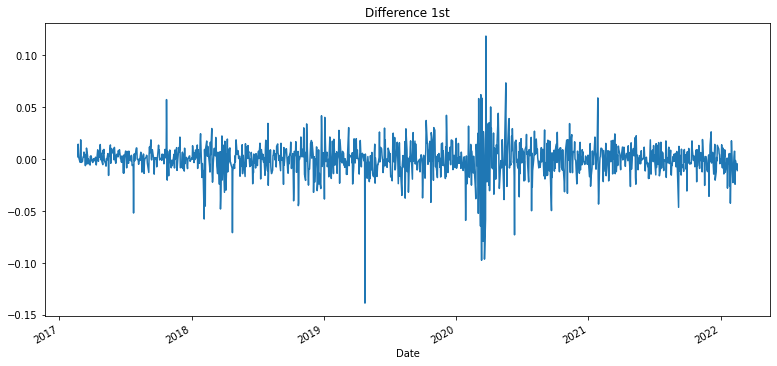

In [224]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### 1차미분에 대한 p-value는 1.475532e-17로 작은 값이며 d = 1값을 사용하였다.

#### STEP 6 : ARIMA 모델 훈련과 테스트  
ARIMA 모델 빌드와 훈련  
모델 테스트 및 플로팅  
최종 예측 모델 정확도 측정(MAPE)

In [225]:
# Build and Train  Model
model = ARIMA(train_data, order=(13, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1196
Model:                ARIMA(13, 1, 0)   Log Likelihood                3267.365
Date:                Thu, 17 Feb 2022   AIC                          -6506.729
Time:                        21:45:18   BIC                          -6435.526
Sample:                             0   HQIC                         -6479.902
                               - 1196                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0221      0.020     -1.112      0.266      -0.061       0.017
ar.L2         -0.0484      0.022     -2.209      0.027      -0.091      -0.005
ar.L3         -0.0284      0.024     -1.190      0.2

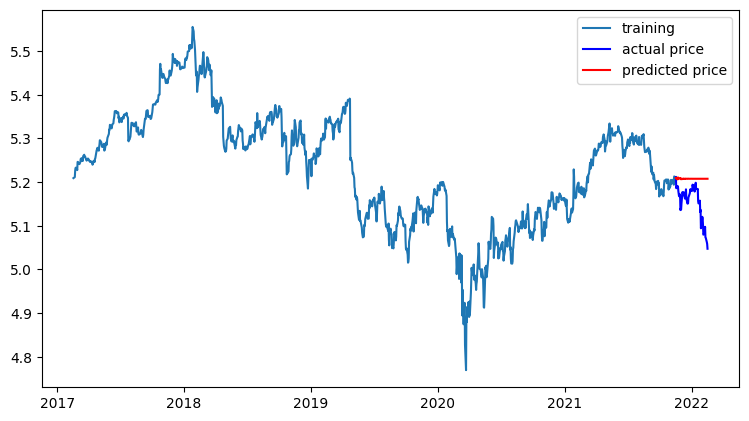

In [226]:

fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [227]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  139.44904334503465
MAE:  9.672919380876985
RMSE:  11.808854446771484
MAPE: 5.76%


## 후기  

#### 세 종목에 대한 p-value가 0.5~0.91 사이로 주가의 예측은 불가능한 것이었다. 그래프도 예측이라고 할 수도 없는 시작시점부터 거의 일직선으로 그어버린 형태가 되었다.

#### 주가에 주기성이나 계절성이 있었다면 주식시장이 있을 이유가 없을 것이다.

#### 주가의 예측은 시장경제에 영향을 미치는 요소들을 고려하여 계산되어야 할 것이다.
